In [1]:
import numpy as np
import matplotlib.pyplot as plt


def load_from_csv(file):
    """file: filename
       return: 
           features: np.array[ncases, nfeatures]
           descriptions: list[nfeatures]
           correct_answers: np.array[ncases]
    """
    raw_data = np.genfromtxt(file, delimiter=',', names=True)
    raw_descriptions = list(raw_data.dtype.names)
    raw_data = np.array(list(map(list, raw_data)))
    
    features = raw_data[:, 1:-1]
    descriptions = raw_descriptions[1:-1]
    correct_answers = raw_data[:,-1]  
    return features, descriptions, correct_answers


def save_to_csv(descriptions, features, correct_answers, file):
    """descriptions: list[nfeatures]
       features: np.array[ncases, nfeatures]
       correct_answers: np.array[ncases]
       file: filename
    """
    f = open(file, 'wt')
    descriptions = ["ID"] + descriptions + ["default.payment.next.month"]
    print(','.join(descriptions), file=f)
    for i in range(features.shape[0]):
        print("%i,%s,%f" % (i+1, ','.join(map(str, features[i])), correct_answers[i]), file=f)
    f.close()
 
    
def add_feature(features, descriptions, new_feature, new_description):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        new_feature: np.array[ncases]
        new_description: str
        return:
            new_features: np.array[ncases, nfeatures+1]
            new_descriptions: list[nfeatures+1]
            
    """
    new_features, new_descriptions = add_features(features, descriptions, new_feature[:,np.newaxis], [new_description])
    return new_features, new_descriptions


def add_features(features, descriptions, new_features, new_descriptions):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        new_features: np.array[ncases, nnewfeatures]
        new_descriptions: list[nnewfeatures]
        return:
            new_new_features: np.array[ncases, nfeatures+nnewfeatures]
            new_new_descriptions: list[nfeatures+nnewfeatures]
    """
    new_new_features = np.concatenate([features, new_features],1)
    new_new_descriptions = descriptions + new_descriptions
    return new_new_features, new_new_descriptions
    
def add_one_hot_encoded_feature(features, descriptions, feature, description):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        feature: np.array[ncases]
        description: str
        return:
            new_features: np.array[ncases, nfeatures+1]
            new_descriptions: list[nfeatures+1]
    """
    hot_features, hot_descriptions = one_hot_encoded_feature(feature, description)
    new_features = np.concatenate([features, hot_features], 1)
    new_descriptions = descriptions + hot_descriptions
    return new_features, new_descriptions

def one_hot_encoded_feature(feature, description):
    """
        feature: np.array[ncases]
        description: str
        return:
            new_features: np.array[ncases,n_one_hot_encoded_features]
            new_descriptions: list[n_one_hot_encoded_features]
    """
    unique_values = sorted(set(feature)) #сколько столбцов
    new_descriptions = []
    for i in range(len(unique_values)):
        new_descriptions.append(description + " = " + str(unique_values[i]))
    feature = feature[:,np.newaxis]
    unique_values = np.array(unique_values)
    unique_values = unique_values[np.newaxis,:]      
    return (feature == unique_values).astype(np.float), new_descriptions

def make_uniform_borders(feature, c_diapasones):
    """
    feature: np.array[ncases]
    c_diapasones: int
    return:
        uniform_borders: list[c_diapasones-1]
    """
    max_diap = np.max(feature)
    min_diap = np.min(feature)
    diap = max_diap - min_diap
    step = diap / c_diapasones##20
    uniform_borders=[]
    for i in range(1, c_diapasones):
        uniform_borders.append(min_diap + step * i)   
    return uniform_borders

def make_quantile_borders(feature, c_diapasones):
    """
    feature: np.array[ncases]
    c_diapasones: int
    return:
        quantile_borders: list[c_diapasones-1]
    """
    quantile_numbers = make_uniform_borders([0, 1], c_diapasones)
    feature = sorted(feature)
    quantile_borders = []
    for i in range(0, c_diapasones - 1):
        quantile_borders.append(get_quantile_element(feature, quantile_numbers[i]))
    return quantile_borders

def get_quantile_element(sorted_feature, quantile_number):
    """
    sorted_feature: sorted list[ncases]
    quantile_number: int
    return:
        quantile_element: int
    """
    return sorted_feature[int(quantile_number * len(sorted_feature))]
    
def quantificator(feature, description, borders):
    """
    feature: np.array[ncases]
    description: str
    borders: list[nborders]
    return:
        new_features: np.array[ncases,nborders+1]
        new_descriptions: list[nborders+1]
    """
    borders = sorted(borders)
    f1 = feature < borders[0]
    d1 = description + " < %f" %borders[0]
    
    fi = []
    di = []
    for i in range(0, len(borders)-1):
        fi.append(np.logical_and(feature >= borders[i], feature < borders[i+1]))
        di.append(("%f <="%borders[i]) + description + " < %f" %borders[i+1])
    flast = feature >= borders[-1]
    dlast = ("%f <="%borders[-1]) + description
    
    new_features = np.stack([f1] + fi + [flast], axis=1)
    new_descriptions = [d1] + di + [dlast]
    
    return new_features.astype(np.float32), new_descriptions

def add_qr_feature(features, descriptions, feature, description, c_diapasones):
    """
    features: np.array[ncases, nfeatures]
    descriptions: list[nfeatures]
    feature: np.array[ncases]
    description: str
    c_diapasones: int
    return:
        new_features: np.array[ncases,2*c_diapasones-1]
        new_descriptions: list[2*c_diapasones-1]
    
    """
    uniform_borders = []#make_uniform_borders(feature, c_diapasones)
    quantile_borders = make_quantile_borders(feature, c_diapasones)
    all_borders = uniform_borders + quantile_borders
    new_features, new_descriptions = quantificator(feature, description, all_borders)  
    new_features, new_descriptions = add_features(features, descriptions, new_features, new_descriptions)
    return new_features, new_descriptions

def analyze(features, descriptions):
    std_dev = np.apply_along_axis(np.std, 0, features)
    mean = np.apply_along_axis(np.mean, 0, features)
    for i in range(features.shape[1]):
        print('%r:======================================================================' %(i))
        print(descriptions[i])
        print("std_dev", std_dev[i])
        print("mean", mean[i])
        print("min", np.min(features[:,i]))
        print("max", np.max(features[:,i]))
        n, bins, patches = plt.hist(features[:,i], 20, normed=0, facecolor='red',)
        plt.show()

LIMIT_BAL = 0
SEX = 1
EDUCATION = 2
MARRIAGE = 3
AGE = 4
PAY_0 = 5 
PAY_2 = 6 
PAY_3 = 7
PAY_4 = 8
PAY_5 = 9
PAY_6 = 10
BILL_AMT1 = 11
BILL_AMT2 = 12
BILL_AMT3 = 13
BILL_AMT4 = 14
BILL_AMT5 = 15
BILL_AMT6 = 16
PAY_AMT1 = 17
PAY_AMT2 = 18
PAY_AMT3 = 19
PAY_AMT4 = 20
PAY_AMT5 = 21
PAY_AMT6 = 22

ModuleNotFoundError: No module named 'matplotlib'

In [24]:
np.set_printoptions(300000)
features, descriptions, correct_answers = load_from_csv('ccard.csv')

# Feature 0.
nf = np.ones((features.shape[0], 1))
nd = ["1"]

# Feature 1.
f = features[:,LIMIT_BAL]
f = np.log(f)
f = (f - np.min(f))/(max(f) - np.min(f))
#print(f)
nf, nd = add_feature(nf, nd, f, "LOG(%s)"%descriptions[LIMIT_BAL])

# Feature 2.
nf, nd = add_one_hot_encoded_feature(nf, nd, features[:,SEX], descriptions[SEX]) 

# Feature 3.
f = features[:, EDUCATION]
f[f>3] = 0
nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[EDUCATION])

# Feature 4.
f = features[:, MARRIAGE]
f[f==3] = 0
nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[MARRIAGE]) 

# Feature 5.
nf, nd = add_qr_feature(nf, nd, features[:, AGE], descriptions[AGE], 5)

# Feature 6.
for i in range(PAY_0, PAY_6+1):
    f = features[:, i]
    f[f>3]=3   
    nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[i]) 
    
# Feature 7.
for i in range(BILL_AMT1, BILL_AMT6+1):
    nf, nd = add_qr_feature(nf, nd, features[:, i], descriptions[i], 5)
    
# Feature 8.
for i in range(BILL_AMT1, BILL_AMT6+1):
    f = features[:, i] / features[:, LIMIT_BAL]
    d = descriptions[i] + "/" + descriptions[LIMIT_BAL]
    nf, nd = add_qr_feature(nf, nd, f, d, 5)

# Feature 9.
for i in range(PAY_AMT1, PAY_AMT6+1):
    nf, nd = add_qr_feature(nf, nd, features[:, i], descriptions[i], 5)

# Feature 12.
for i in range(PAY_AMT1, PAY_AMT6+1):
    f = features[:, i] / features[:, LIMIT_BAL]
    d = descriptions[i] + "/" + descriptions[LIMIT_BAL]
    nf, nd = add_qr_feature(nf, nd, f, d, 5)
    
# Feature Scaling
 

# Debug printing.
print(nf.shape)
print(np.sum(nf==0,axis=0))
print(nd)
print("ok")

(30000, 170)
[    0   493 18112 11888 29532 19415 15970 25083 29623 16341 14036 24873
 24114 23096 24573 23344 27241 24314 15263 26312 27333 29537 26218 23950
 14270 29972 26073 29517 25915 24062 14236 29996 26181 29610 25652 24313
 13545 29998 26841 29651 25454 24461 13053 27374 29658 25105 24260 13714
 27234 29687 24000 24000 24000 24000 24000 24000 24000 24000 24000 24000
 24000 24000 24001 23999 24000 24001 24000 23999 24001 23999 24001 23999
 24000 24000 24000 24005 23995 24000 24000 24000 24001 23999 24000 24000
 24000 24000 24000 24001 23999 24000 24000 24000 24000 24000 24000 24000
 24000 24000 24000 24000 24000 24008 23992 24000 24000 24001 23999 24000
 24000 24000 24060 23944 24771 23225 24000 24000 24074 24235 23912 23779
 24000 24004 24010 23986 24000 30000 18612 23445 24553 23390 30000 18630
 23370 24621 23379 30000 18275 23732 24520 23473 24000 24017 24131 23852
 24000 24002 23998 24002 24355 23643 24000 24000 24000 24006 23994 30000
 18000 24002 24065 23933 30000 18021 2

0:======================================================================
LIMIT_BAL
std_dev 129745.499088
mean 167484.322667
min 10000.0
max 1000000.0


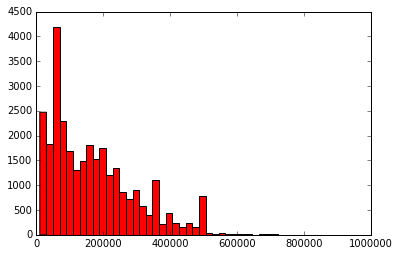

1:======================================================================
SEX
std_dev 0.489121043869
mean 1.60373333333
min 1.0
max 2.0


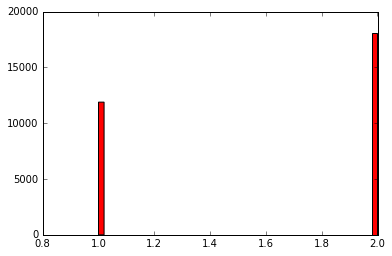

2:======================================================================
EDUCATION
std_dev 0.728474192329
mean 1.77986666667
min 0.0
max 3.0


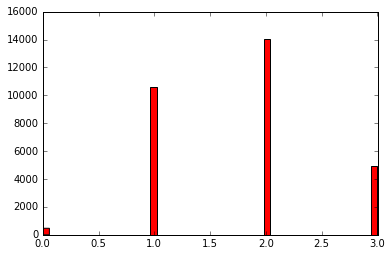

3:======================================================================
MARRIAGE
std_dev 0.524166461049
mean 1.51956666667
min 0.0
max 2.0


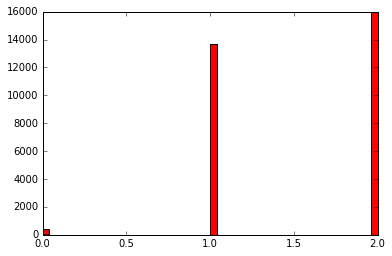

4:======================================================================
AGE
std_dev 9.21775043508
mean 35.4855
min 21.0
max 79.0


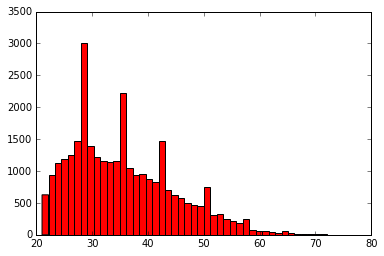

5:======================================================================
PAY_0
std_dev 1.08357492229
mean -0.0264333333333
min -2.0
max 3.0


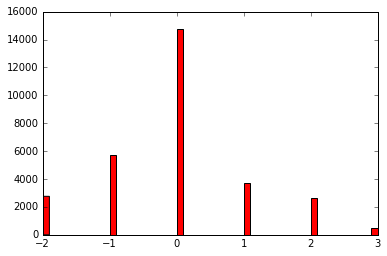

6:======================================================================
PAY_2
std_dev 1.1640379485
mean -0.142766666667
min -2.0
max 3.0


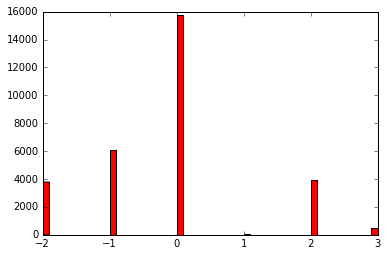

7:======================================================================
PAY_3
std_dev 1.15661978003
mean -0.176533333333
min -2.0
max 3.0


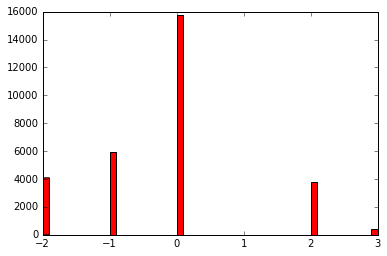

8:======================================================================
PAY_4
std_dev 1.11381014939
mean -0.233866666667
min -2.0
max 3.0


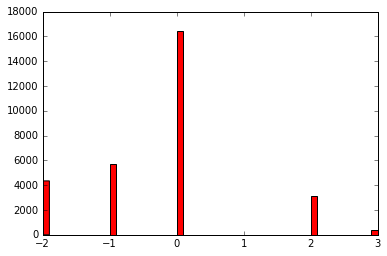

9:======================================================================
PAY_5
std_dev 1.07980316673
mean -0.278433333333
min -2.0
max 3.0


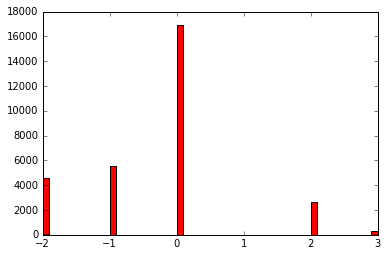

10:======================================================================
PAY_6
std_dev 1.10250448172
mean -0.301966666667
min -2.0
max 3.0


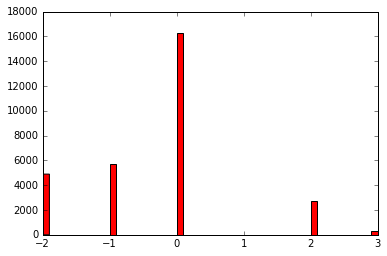

11:======================================================================
BILL_AMT1
std_dev 73634.633301
mean 51223.3309
min -165580.0
max 964511.0


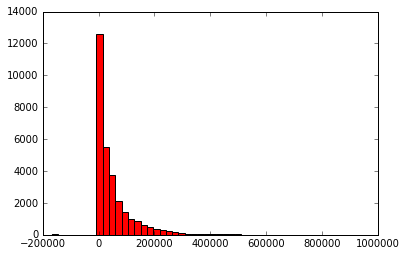

12:======================================================================
BILL_AMT2
std_dev 71172.5825432
mean 49179.0751667
min -69777.0
max 983931.0


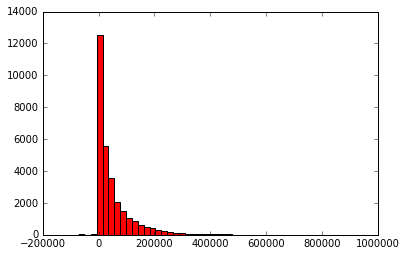

13:======================================================================
BILL_AMT3
std_dev 69348.2315943
mean 47013.1548
min -157264.0
max 1664089.0


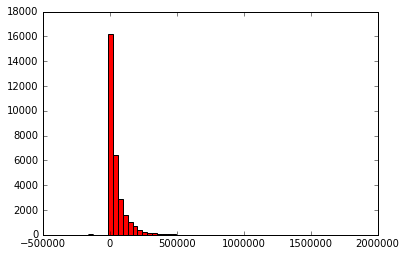

14:======================================================================
BILL_AMT4
std_dev 64331.7839107
mean 43262.9489667
min -170000.0
max 891586.0


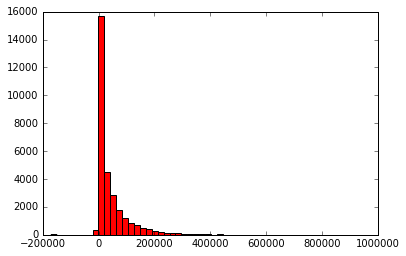

15:======================================================================
BILL_AMT5
std_dev 60796.1424759
mean 40311.4009667
min -81334.0
max 927171.0


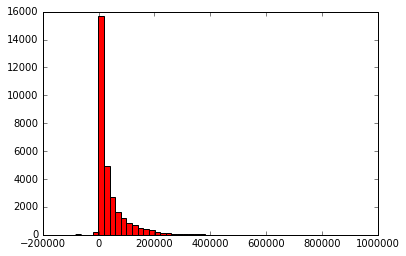

16:======================================================================
BILL_AMT6
std_dev 59553.11496
mean 38871.7604
min -339603.0
max 961664.0


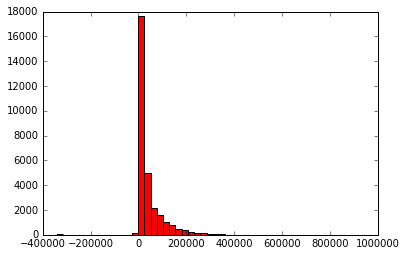

17:======================================================================
PAY_AMT1
std_dev 16563.0042971
mean 5663.5805
min 0.0
max 873552.0


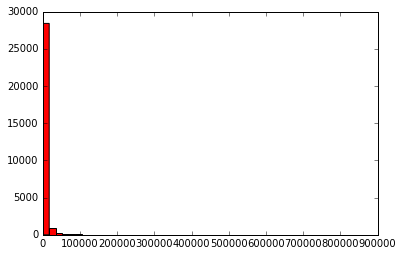

18:======================================================================
PAY_AMT2
std_dev 23040.4863844
mean 5921.1635
min 0.0
max 1684259.0


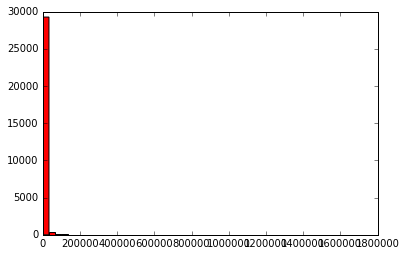

19:======================================================================
PAY_AMT3
std_dev 17606.668018
mean 5225.6815
min 0.0
max 896040.0


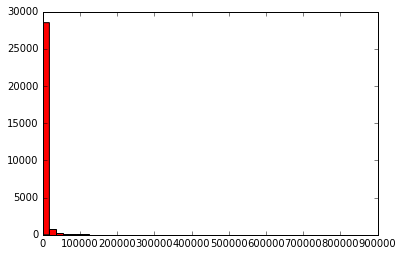

20:======================================================================
PAY_AMT4
std_dev 15665.8986392
mean 4826.07686667
min 0.0
max 621000.0


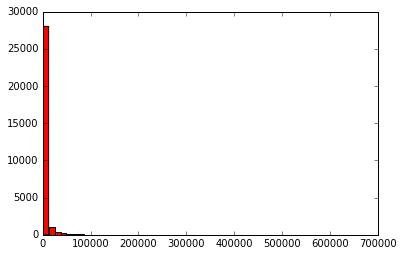

21:======================================================================
PAY_AMT5
std_dev 15278.0510386
mean 4799.38763333
min 0.0
max 426529.0


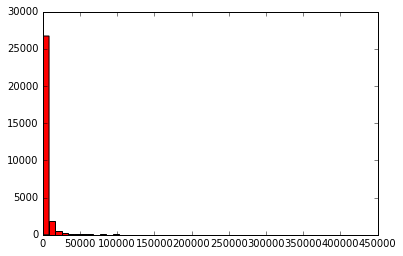

22:======================================================================
PAY_AMT6
std_dev 17777.1694819
mean 5215.50256667
min 0.0
max 528666.0


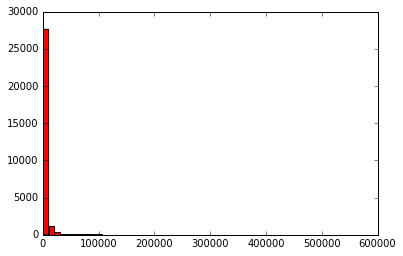

In [4]:
# Analyze
analyze(features, descriptions)

0:======================================================================
1
std_dev 0.0
mean 1.0
min 1.0
max 1.0


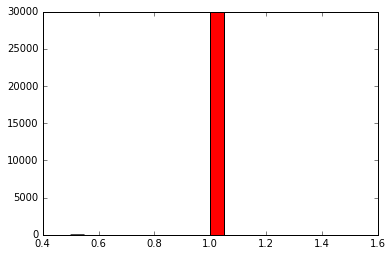

1:======================================================================
LOG(LIMIT_BAL)
std_dev 0.94111915848
mean 11.6630018576
min 9.21034037198
max 13.815510558


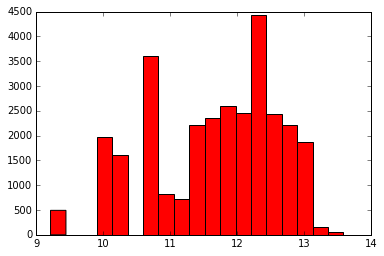

2:======================================================================
SEX = 1.0
std_dev 0.489121043869
mean 0.396266666667
min 0.0
max 1.0


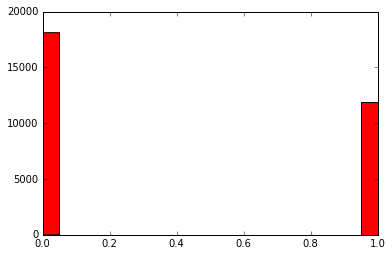

3:======================================================================
SEX = 2.0
std_dev 0.489121043869
mean 0.603733333333
min 0.0
max 1.0


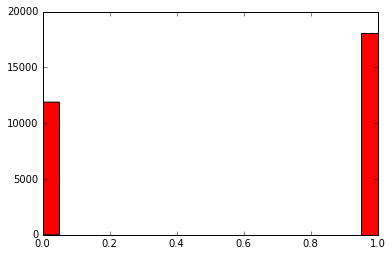

4:======================================================================
EDUCATION = 0.0
std_dev 0.123921910896
mean 0.0156
min 0.0
max 1.0


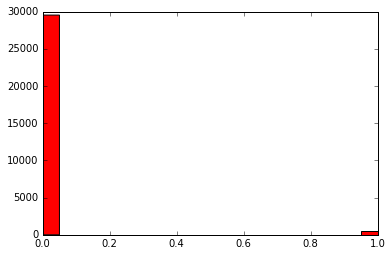

5:======================================================================
EDUCATION = 1.0
std_dev 0.477851412284
mean 0.352833333333
min 0.0
max 1.0


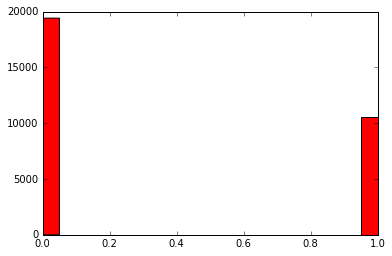

6:======================================================================
EDUCATION = 2.0
std_dev 0.49895346031
mean 0.467666666667
min 0.0
max 1.0


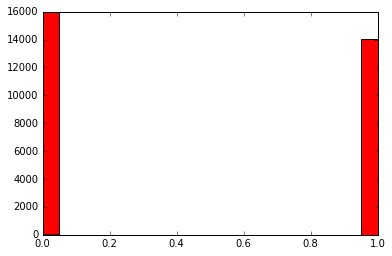

7:======================================================================
EDUCATION = 3.0
std_dev 0.370184805199
mean 0.1639
min 0.0
max 1.0


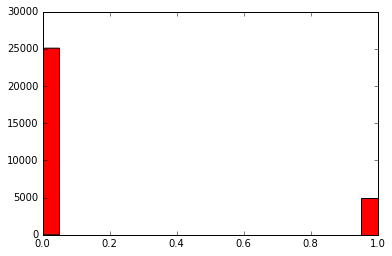

8:======================================================================
MARRIAGE = 0.0
std_dev 0.111394549039
mean 0.0125666666667
min 0.0
max 1.0


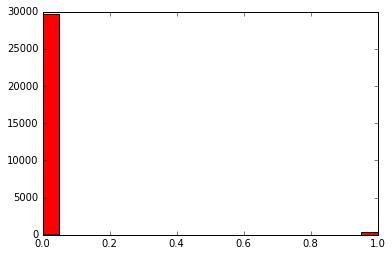

9:======================================================================
MARRIAGE = 1.0
std_dev 0.497997901602
mean 0.4553
min 0.0
max 1.0


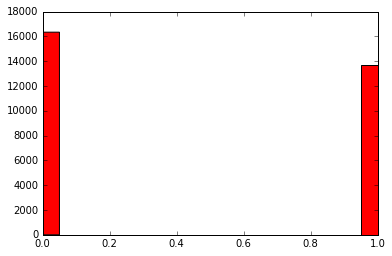

10:======================================================================
MARRIAGE = 2.0
std_dev 0.49896638052
mean 0.532133333333
min 0.0
max 1.0


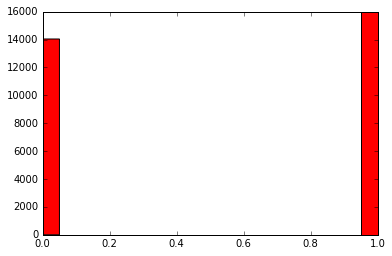

11:======================================================================
AGE < 27.000000
std_dev 0.376421558894
mean 0.1709
min 0.0
max 1.0


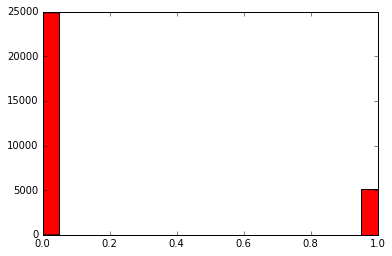

12:======================================================================
27.000000 <=AGE < 31.000000
std_dev 0.39712159347
mean 0.1962
min 0.0
max 1.0


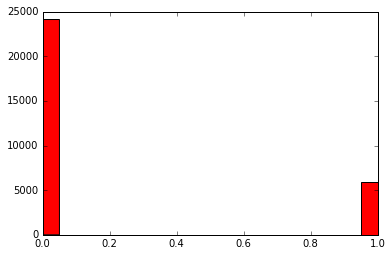

13:======================================================================
31.000000 <=AGE < 37.000000
std_dev 0.420918023162
mean 0.230133333333
min 0.0
max 1.0


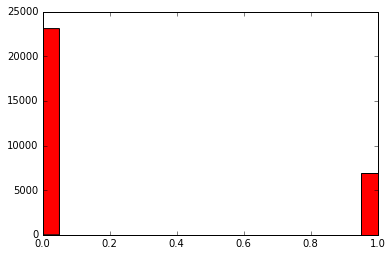

14:======================================================================
37.000000 <=AGE < 43.000000
std_dev 0.384935306253
mean 0.1809
min 0.0
max 1.0


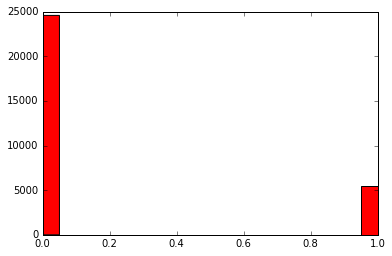

15:======================================================================
43.000000 <=AGE
std_dev 0.41550192405
mean 0.221866666667
min 0.0
max 1.0


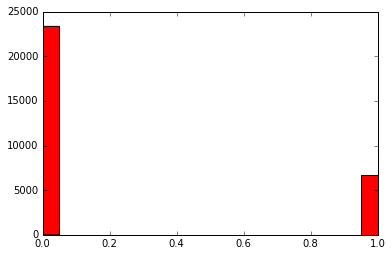

16:======================================================================
PAY_0 = -2.0
std_dev 0.28897889004
mean 0.0919666666667
min 0.0
max 1.0


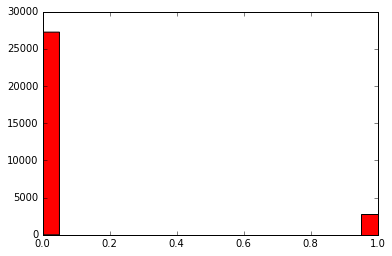

17:======================================================================
PAY_0 = -1.0
std_dev 0.391931689059
mean 0.189533333333
min 0.0
max 1.0


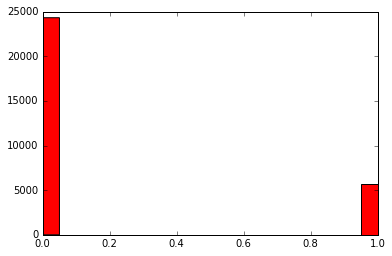

18:======================================================================
PAY_0 = 0.0
std_dev 0.499923139648
mean 0.491233333333
min 0.0
max 1.0


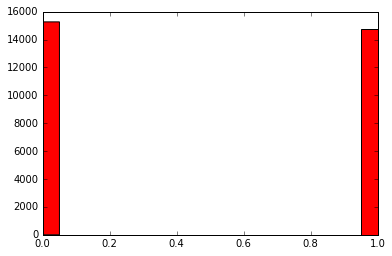

19:======================================================================
PAY_0 = 1.0
std_dev 0.328360668913
mean 0.122933333333
min 0.0
max 1.0


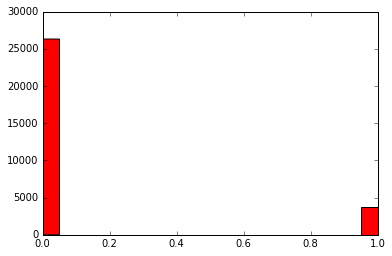

20:======================================================================
PAY_0 = 2.0
std_dev 0.284599349964
mean 0.0889
min 0.0
max 1.0


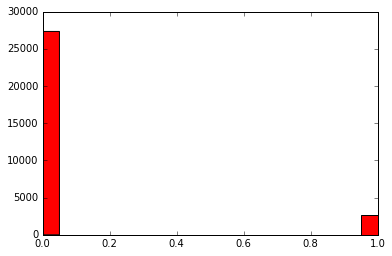

21:======================================================================
PAY_0 = 3.0
std_dev 0.123268591115
mean 0.0154333333333
min 0.0
max 1.0


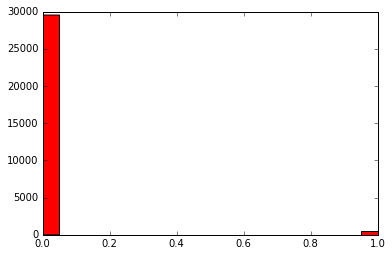

22:======================================================================
PAY_2 = -2.0
std_dev 0.33192448271
mean 0.126066666667
min 0.0
max 1.0


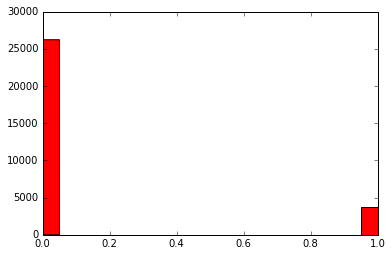

23:======================================================================
PAY_2 = -1.0
std_dev 0.401244591518
mean 0.201666666667
min 0.0
max 1.0


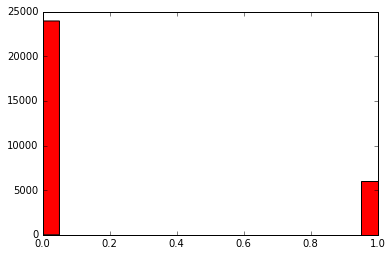

24:======================================================================
PAY_2 = 0.0
std_dev 0.499407537878
mean 0.524333333333
min 0.0
max 1.0


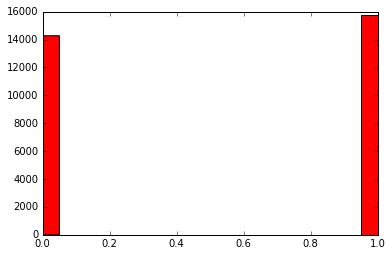

25:======================================================================
PAY_2 = 1.0
std_dev 0.0305362444027
mean 0.000933333333333
min 0.0
max 1.0


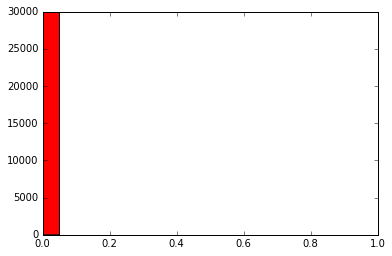

26:======================================================================
PAY_2 = 2.0
std_dev 0.337290957483
mean 0.1309
min 0.0
max 1.0


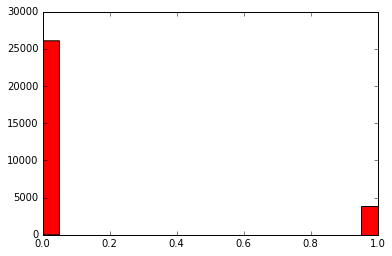

27:======================================================================
PAY_2 = 3.0
std_dev 0.125860200222
mean 0.0161
min 0.0
max 1.0


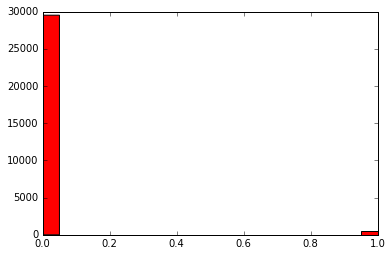

28:======================================================================
PAY_3 = -2.0
std_dev 0.342965458254
mean 0.136166666667
min 0.0
max 1.0


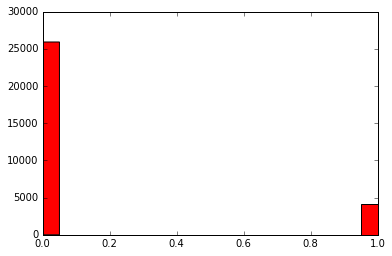

29:======================================================================
PAY_3 = -1.0
std_dev 0.398441625447
mean 0.197933333333
min 0.0
max 1.0


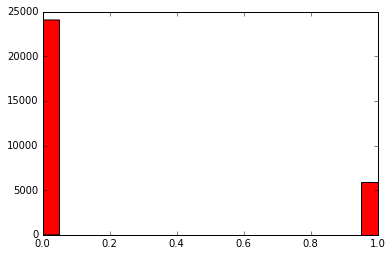

30:======================================================================
PAY_3 = 0.0
std_dev 0.499351027724
mean 0.525466666667
min 0.0
max 1.0


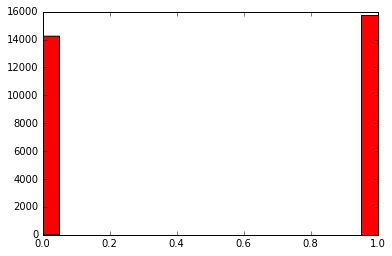

31:======================================================================
PAY_3 = 1.0
std_dev 0.0115462355578
mean 0.000133333333333
min 0.0
max 1.0


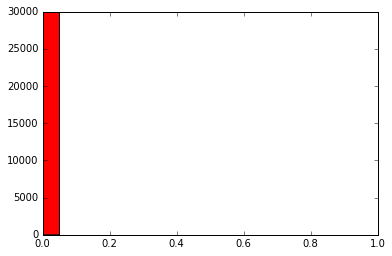

32:======================================================================
PAY_3 = 2.0
std_dev 0.333308730759
mean 0.1273
min 0.0
max 1.0


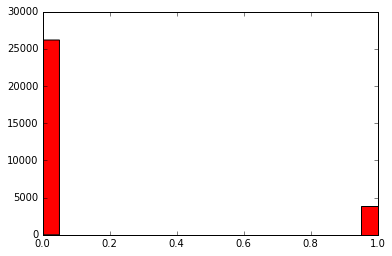

33:======================================================================
PAY_3 = 3.0
std_dev 0.113274004079
mean 0.013
min 0.0
max 1.0


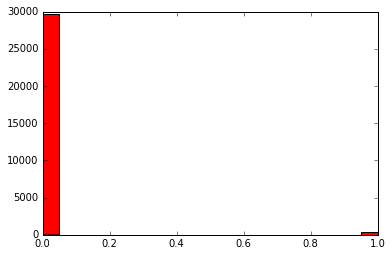

34:======================================================================
PAY_4 = -2.0
std_dev 0.352033609507
mean 0.144933333333
min 0.0
max 1.0


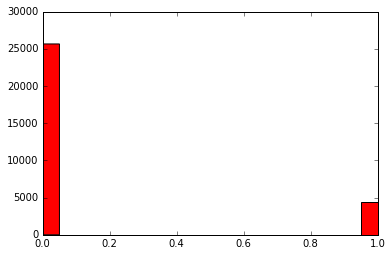

35:======================================================================
PAY_4 = -1.0
std_dev 0.391958091581
mean 0.189566666667
min 0.0
max 1.0


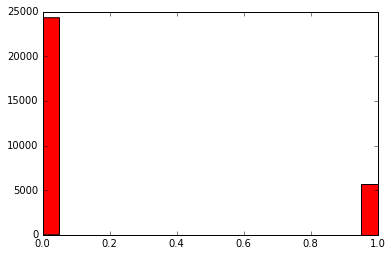

36:======================================================================
PAY_4 = 0.0
std_dev 0.497642190735
mean 0.5485
min 0.0
max 1.0


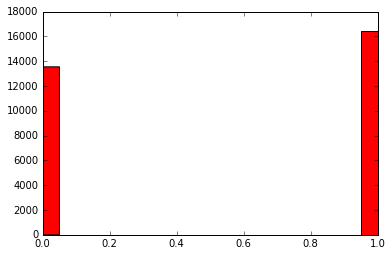

37:======================================================================
PAY_4 = 1.0
std_dev 0.00816469363921
mean 6.66666666667e-05
min 0.0
max 1.0


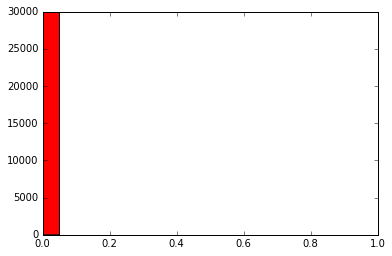

38:======================================================================
PAY_4 = 2.0
std_dev 0.30693958689
mean 0.1053
min 0.0
max 1.0


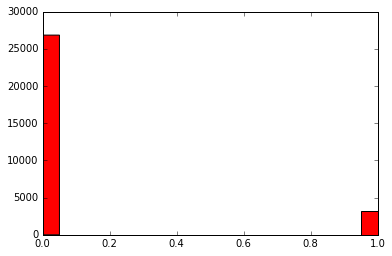

39:======================================================================
PAY_4 = 3.0
std_dev 0.107228722313
mean 0.0116333333333
min 0.0
max 1.0


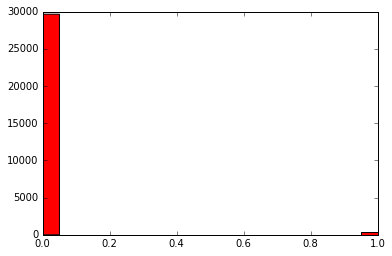

40:======================================================================
PAY_5 = -2.0
std_dev 0.358567960396
mean 0.151533333333
min 0.0
max 1.0


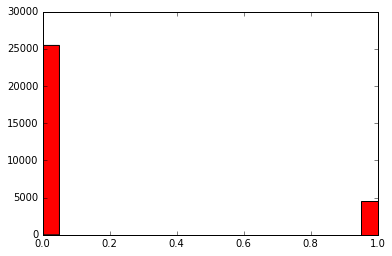

41:======================================================================
PAY_5 = -1.0
std_dev 0.387999826747
mean 0.184633333333
min 0.0
max 1.0


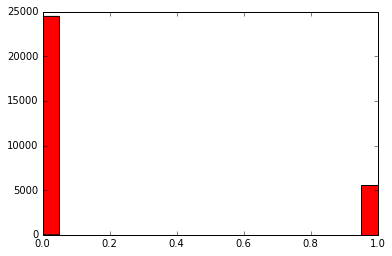

42:======================================================================
PAY_5 = 0.0
std_dev 0.495770097928
mean 0.5649
min 0.0
max 1.0


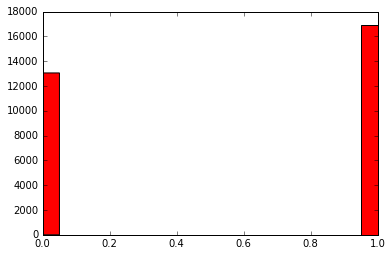

43:======================================================================
PAY_5 = 2.0
std_dev 0.282615018866
mean 0.0875333333333
min 0.0
max 1.0


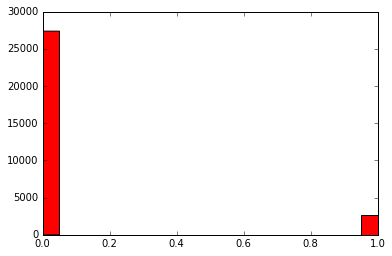

44:======================================================================
PAY_5 = 3.0
std_dev 0.106160444611
mean 0.0114
min 0.0
max 1.0


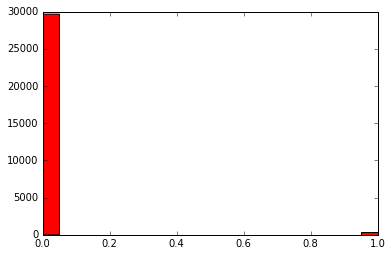

45:======================================================================
PAY_6 = -2.0
std_dev 0.369517666094
mean 0.163166666667
min 0.0
max 1.0


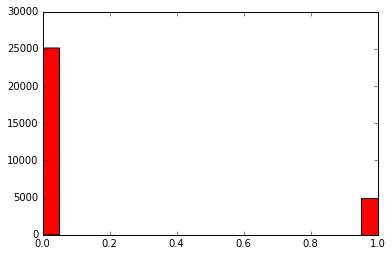

46:======================================================================
PAY_6 = -1.0
std_dev 0.393350847068
mean 0.191333333333
min 0.0
max 1.0


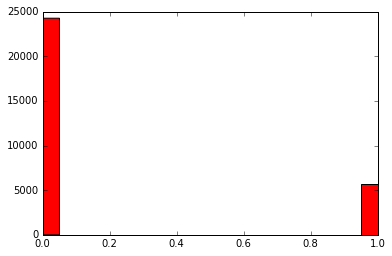

47:======================================================================
PAY_6 = 0.0
std_dev 0.498159059828
mean 0.542866666667
min 0.0
max 1.0


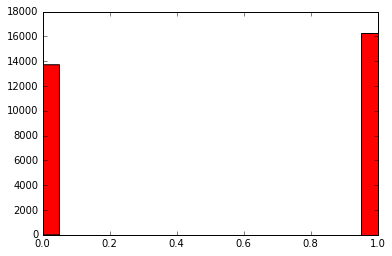

48:======================================================================
PAY_6 = 2.0
std_dev 0.289308071094
mean 0.0922
min 0.0
max 1.0


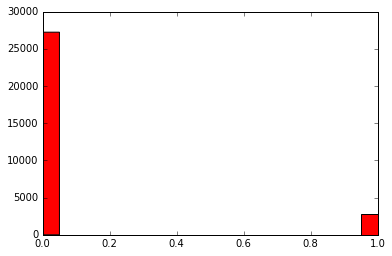

49:======================================================================
PAY_6 = 3.0
std_dev 0.101609442912
mean 0.0104333333333
min 0.0
max 1.0


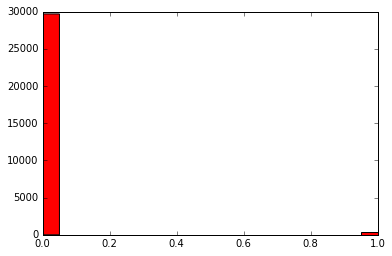

50:======================================================================
BILL_AMT1 < 1893.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


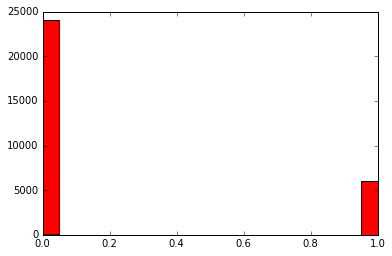

51:======================================================================
1893.000000 <=BILL_AMT1 < 13470.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


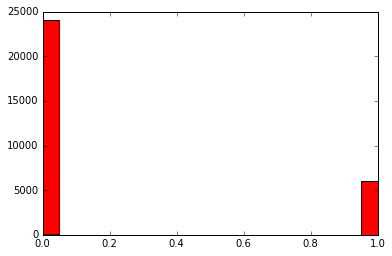

52:======================================================================
13470.000000 <=BILL_AMT1 < 37050.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


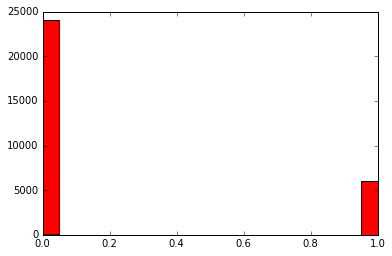

53:======================================================================
37050.000000 <=BILL_AMT1 < 83446.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


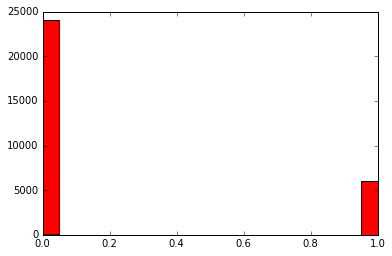

54:======================================================================
83446.000000 <=BILL_AMT1
std_dev 0.4
mean 0.2
min 0.0
max 1.0


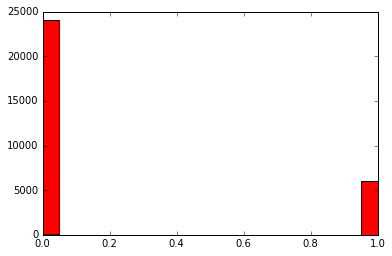

55:======================================================================
BILL_AMT2 < 1473.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


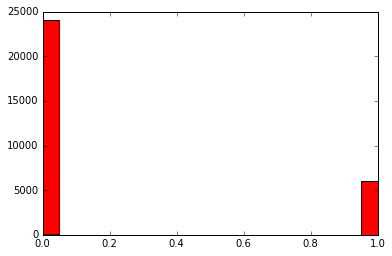

56:======================================================================
1473.000000 <=BILL_AMT2 < 12800.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


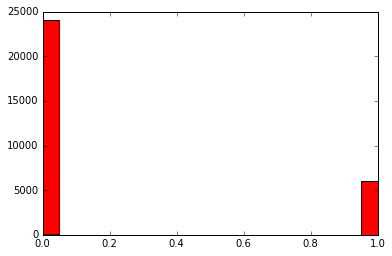

57:======================================================================
12800.000000 <=BILL_AMT2 < 34775.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


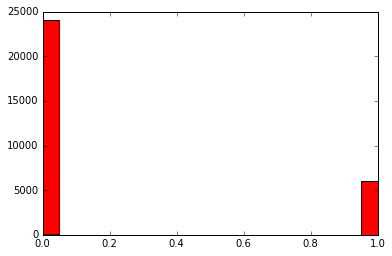

58:======================================================================
34775.000000 <=BILL_AMT2 < 80301.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


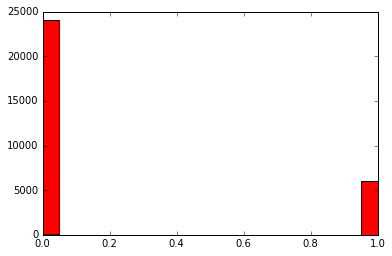

59:======================================================================
80301.000000 <=BILL_AMT2
std_dev 0.4
mean 0.2
min 0.0
max 1.0


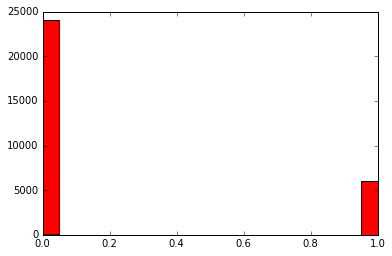

60:======================================================================
BILL_AMT3 < 1188.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


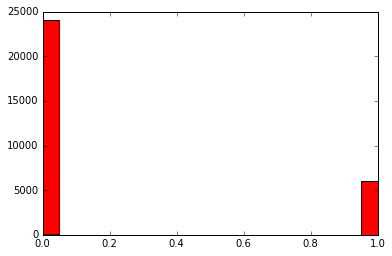

61:======================================================================
1188.000000 <=BILL_AMT3 < 12200.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


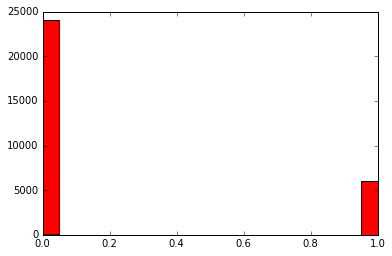

62:======================================================================
12200.000000 <=BILL_AMT3 < 31401.000000
std_dev 0.39997499783
mean 0.199966666667
min 0.0
max 1.0


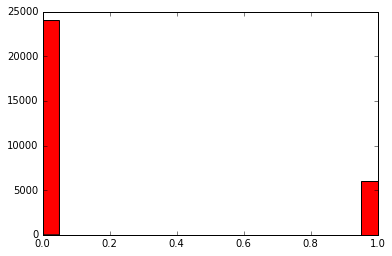

63:======================================================================
31401.000000 <=BILL_AMT3 < 76779.000000
std_dev 0.40002499783
mean 0.200033333333
min 0.0
max 1.0


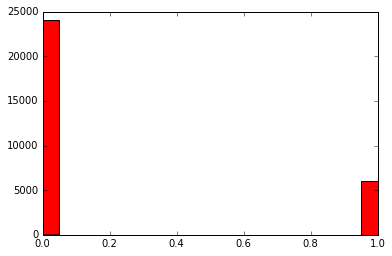

64:======================================================================
76779.000000 <=BILL_AMT3
std_dev 0.4
mean 0.2
min 0.0
max 1.0


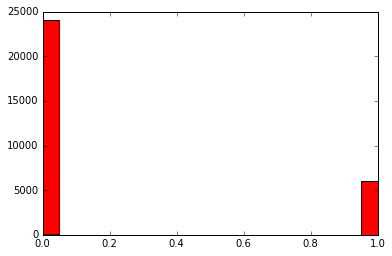

65:======================================================================
BILL_AMT4 < 988.000000
std_dev 0.39997499783
mean 0.199966666667
min 0.0
max 1.0


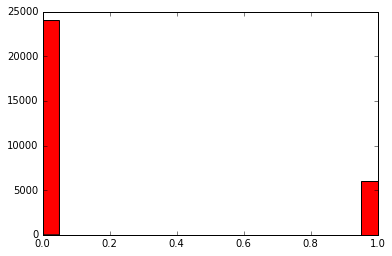

66:======================================================================
988.000000 <=BILL_AMT4 < 11145.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


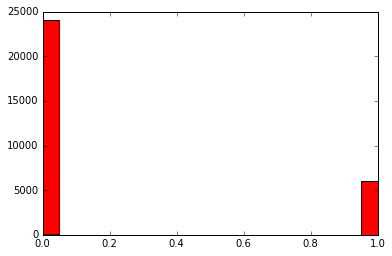

67:======================================================================
11145.000000 <=BILL_AMT4 < 28605.000000
std_dev 0.40002499783
mean 0.200033333333
min 0.0
max 1.0


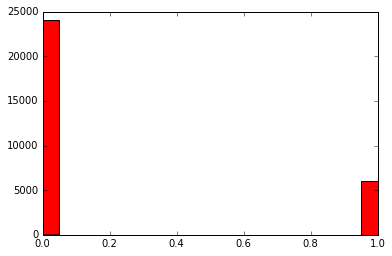

68:======================================================================
28605.000000 <=BILL_AMT4 < 70579.000000
std_dev 0.39997499783
mean 0.199966666667
min 0.0
max 1.0


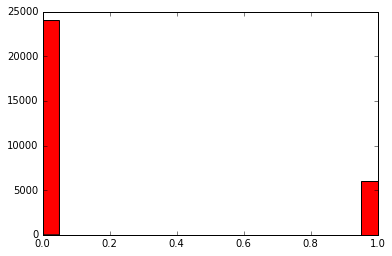

69:======================================================================
70579.000000 <=BILL_AMT4
std_dev 0.40002499783
mean 0.200033333333
min 0.0
max 1.0


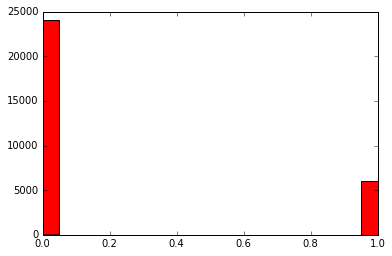

70:======================================================================
BILL_AMT5 < 763.000000
std_dev 0.39997499783
mean 0.199966666667
min 0.0
max 1.0


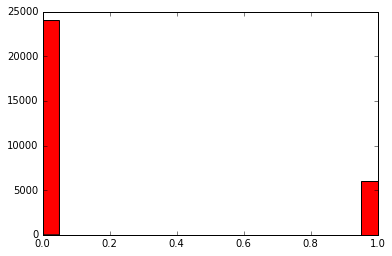

71:======================================================================
763.000000 <=BILL_AMT5 < 9810.000000
std_dev 0.40002499783
mean 0.200033333333
min 0.0
max 1.0


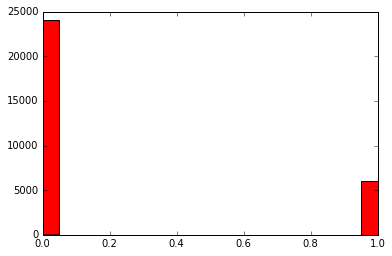

72:======================================================================
9810.000000 <=BILL_AMT5 < 26691.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


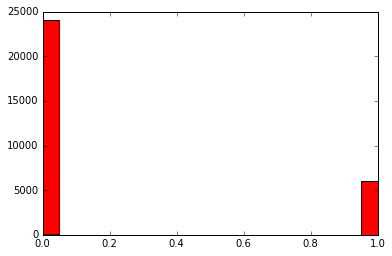

73:======================================================================
26691.000000 <=BILL_AMT5 < 65835.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


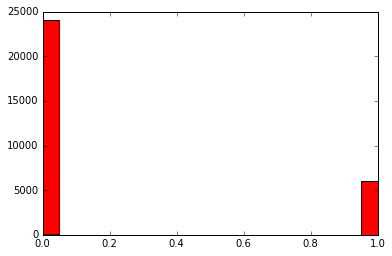

74:======================================================================
65835.000000 <=BILL_AMT5
std_dev 0.4
mean 0.2
min 0.0
max 1.0


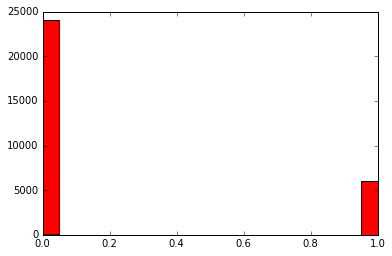

75:======================================================================
BILL_AMT6 < 476.000000
std_dev 0.39987494573
mean 0.199833333333
min 0.0
max 1.0


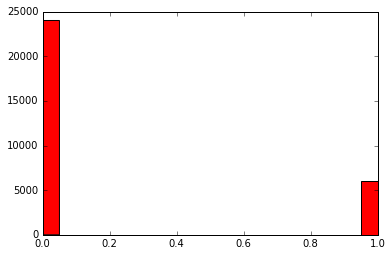

76:======================================================================
476.000000 <=BILL_AMT6 < 8771.000000
std_dev 0.400124945763
mean 0.200166666667
min 0.0
max 1.0


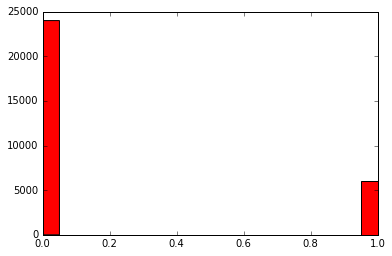

77:======================================================================
8771.000000 <=BILL_AMT6 < 25512.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


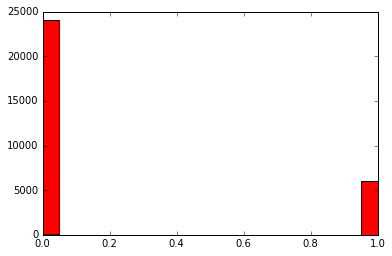

78:======================================================================
25512.000000 <=BILL_AMT6 < 63153.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


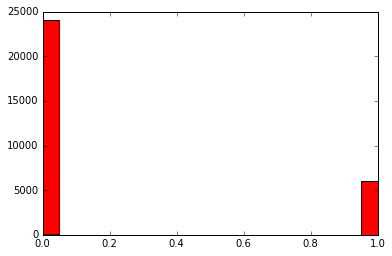

79:======================================================================
63153.000000 <=BILL_AMT6
std_dev 0.4
mean 0.2
min 0.0
max 1.0


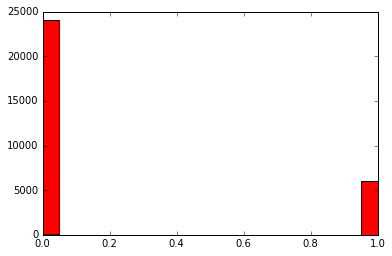

80:======================================================================
BILL_AMT1/LIMIT_BAL < 0.011300
std_dev 0.39997499783
mean 0.199966666667
min 0.0
max 1.0


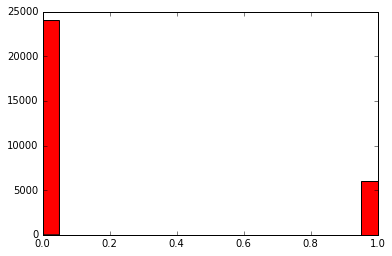

81:======================================================================
0.011300 <=BILL_AMT1/LIMIT_BAL < 0.130800
std_dev 0.40002499783
mean 0.200033333333
min 0.0
max 1.0


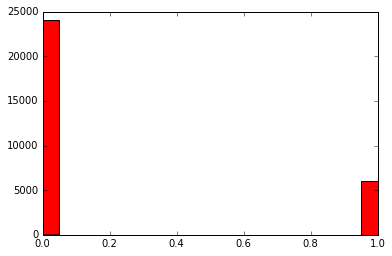

82:======================================================================
0.130800 <=BILL_AMT1/LIMIT_BAL < 0.524124
std_dev 0.4
mean 0.2
min 0.0
max 1.0


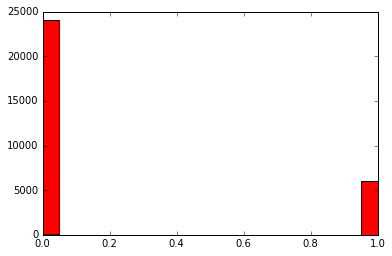

83:======================================================================
0.524124 <=BILL_AMT1/LIMIT_BAL < 0.902430
std_dev 0.4
mean 0.2
min 0.0
max 1.0


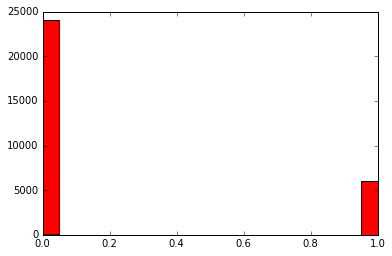

84:======================================================================
0.902430 <=BILL_AMT1/LIMIT_BAL
std_dev 0.4
mean 0.2
min 0.0
max 1.0


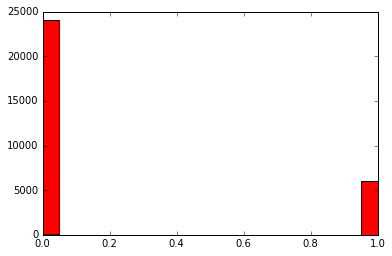

85:======================================================================
BILL_AMT2/LIMIT_BAL < 0.008640
std_dev 0.4
mean 0.2
min 0.0
max 1.0


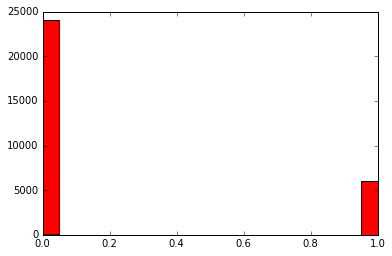

86:======================================================================
0.008640 <=BILL_AMT2/LIMIT_BAL < 0.121546
std_dev 0.4
mean 0.2
min 0.0
max 1.0


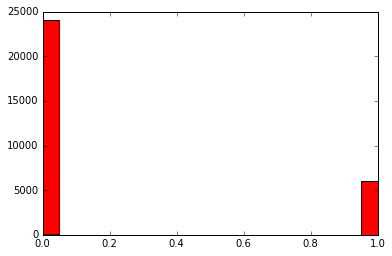

87:======================================================================
0.121546 <=BILL_AMT2/LIMIT_BAL < 0.501500
std_dev 0.39997499783
mean 0.199966666667
min 0.0
max 1.0


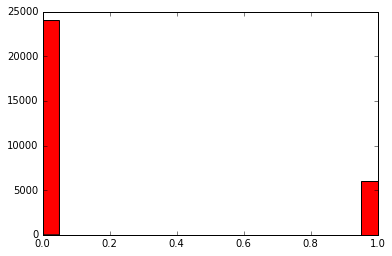

88:======================================================================
0.501500 <=BILL_AMT2/LIMIT_BAL < 0.881600
std_dev 0.40002499783
mean 0.200033333333
min 0.0
max 1.0


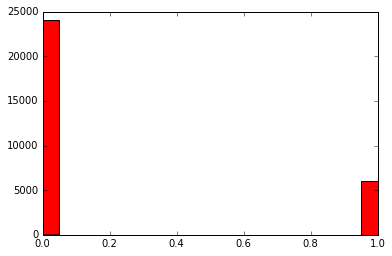

89:======================================================================
0.881600 <=BILL_AMT2/LIMIT_BAL
std_dev 0.4
mean 0.2
min 0.0
max 1.0


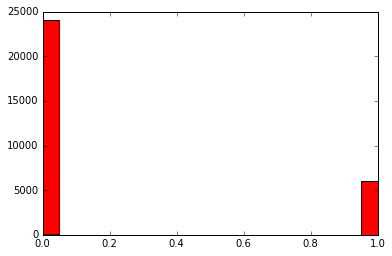

90:======================================================================
BILL_AMT3/LIMIT_BAL < 0.007438
std_dev 0.4
mean 0.2
min 0.0
max 1.0


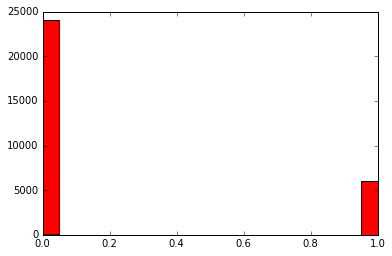

91:======================================================================
0.007438 <=BILL_AMT3/LIMIT_BAL < 0.110187
std_dev 0.4
mean 0.2
min 0.0
max 1.0


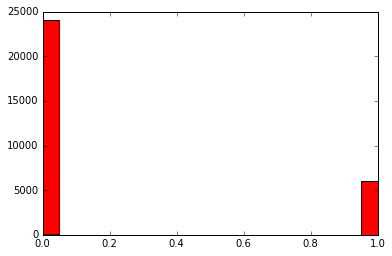

92:======================================================================
0.110187 <=BILL_AMT3/LIMIT_BAL < 0.461089
std_dev 0.4
mean 0.2
min 0.0
max 1.0


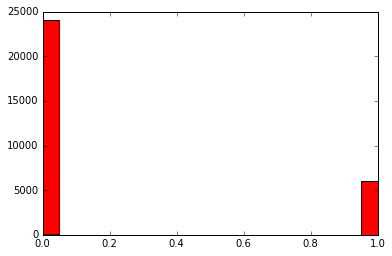

93:======================================================================
0.461089 <=BILL_AMT3/LIMIT_BAL < 0.849314
std_dev 0.4
mean 0.2
min 0.0
max 1.0


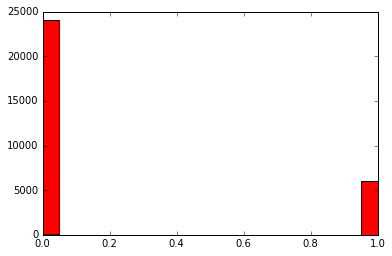

94:======================================================================
0.849314 <=BILL_AMT3/LIMIT_BAL
std_dev 0.4
mean 0.2
min 0.0
max 1.0


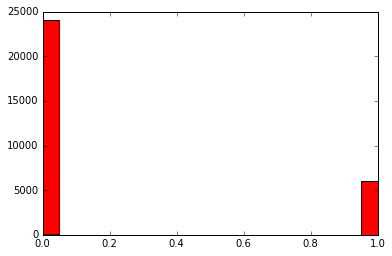

95:======================================================================
BILL_AMT4/LIMIT_BAL < 0.006324
std_dev 0.4
mean 0.2
min 0.0
max 1.0


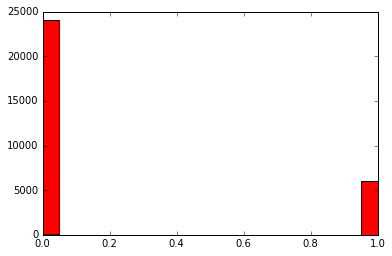

96:======================================================================
0.006324 <=BILL_AMT4/LIMIT_BAL < 0.097567
std_dev 0.4
mean 0.2
min 0.0
max 1.0


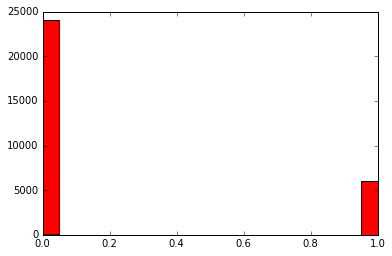

97:======================================================================
0.097567 <=BILL_AMT4/LIMIT_BAL < 0.400260
std_dev 0.4
mean 0.2
min 0.0
max 1.0


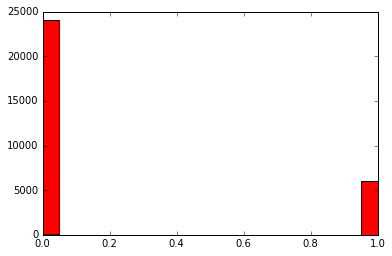

98:======================================================================
0.400260 <=BILL_AMT4/LIMIT_BAL < 0.760200
std_dev 0.4
mean 0.2
min 0.0
max 1.0


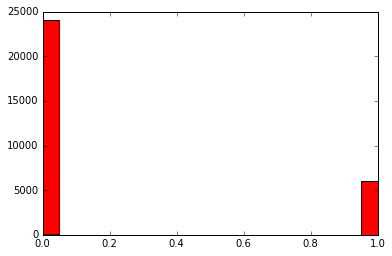

99:======================================================================
0.760200 <=BILL_AMT4/LIMIT_BAL
std_dev 0.4
mean 0.2
min 0.0
max 1.0


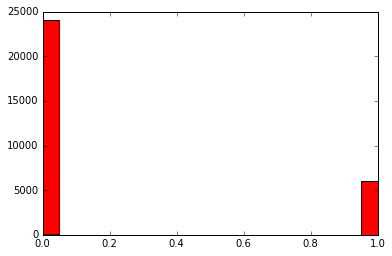

100:======================================================================
BILL_AMT5/LIMIT_BAL < 0.004644
std_dev 0.4
mean 0.2
min 0.0
max 1.0


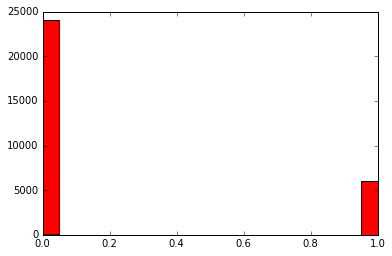

101:======================================================================
0.004644 <=BILL_AMT5/LIMIT_BAL < 0.082500
std_dev 0.399799861042
mean 0.199733333333
min 0.0
max 1.0


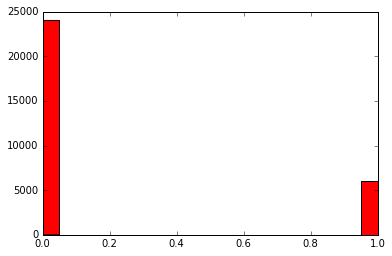

102:======================================================================
0.082500 <=BILL_AMT5/LIMIT_BAL < 0.370667
std_dev 0.40019986118
mean 0.200266666667
min 0.0
max 1.0


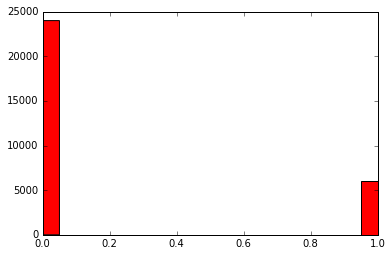

103:======================================================================
0.370667 <=BILL_AMT5/LIMIT_BAL < 0.693592
std_dev 0.4
mean 0.2
min 0.0
max 1.0


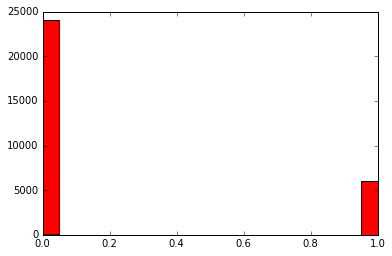

104:======================================================================
0.693592 <=BILL_AMT5/LIMIT_BAL
std_dev 0.4
mean 0.2
min 0.0
max 1.0


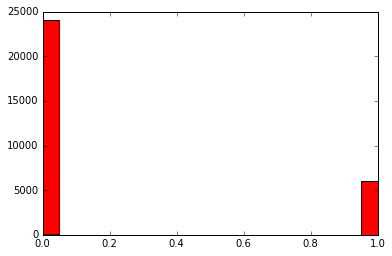

105:======================================================================
BILL_AMT6/LIMIT_BAL < 0.002900
std_dev 0.39997499783
mean 0.199966666667
min 0.0
max 1.0


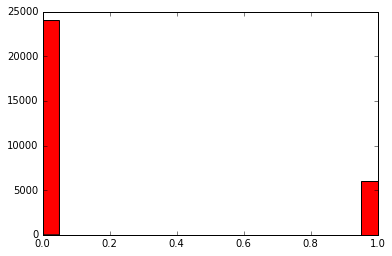

106:======================================================================
0.002900 <=BILL_AMT6/LIMIT_BAL < 0.063914
std_dev 0.40002499783
mean 0.200033333333
min 0.0
max 1.0


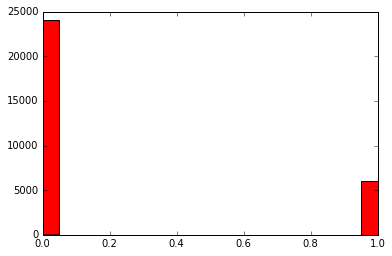

107:======================================================================
0.063914 <=BILL_AMT6/LIMIT_BAL < 0.350267
std_dev 0.4
mean 0.2
min 0.0
max 1.0


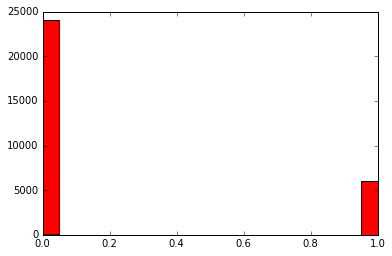

108:======================================================================
0.350267 <=BILL_AMT6/LIMIT_BAL < 0.667826
std_dev 0.4
mean 0.2
min 0.0
max 1.0


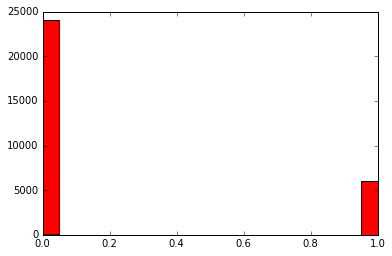

109:======================================================================
0.667826 <=BILL_AMT6/LIMIT_BAL
std_dev 0.4
mean 0.2
min 0.0
max 1.0


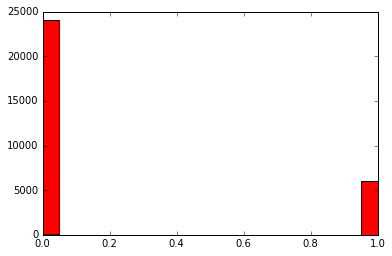

110:======================================================================
PAY_AMT1 < 316.000000
std_dev 0.398492158016
mean 0.198
min 0.0
max 1.0


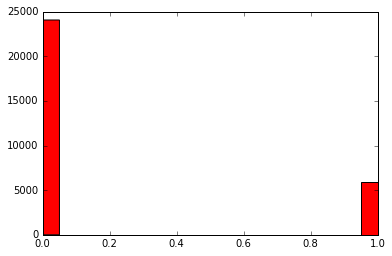

111:======================================================================
316.000000 <=PAY_AMT1 < 1724.000000
std_dev 0.401393218124
mean 0.201866666667
min 0.0
max 1.0


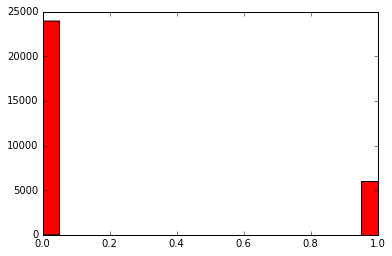

112:======================================================================
1724.000000 <=PAY_AMT1 < 3000.000000
std_dev 0.379367249509
mean 0.1743
min 0.0
max 1.0


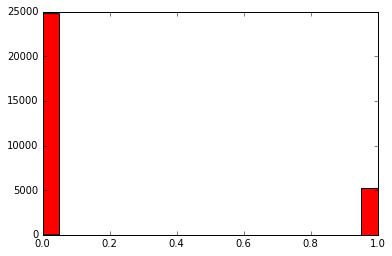

113:======================================================================
3000.000000 <=PAY_AMT1 < 6193.000000
std_dev 0.41812993063
mean 0.225833333333
min 0.0
max 1.0


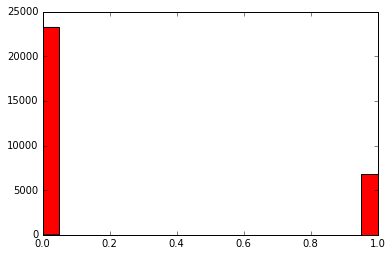

114:======================================================================
6193.000000 <=PAY_AMT1
std_dev 0.4
mean 0.2
min 0.0
max 1.0


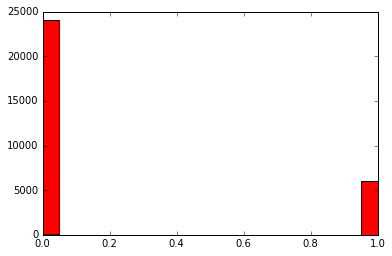

115:======================================================================
PAY_AMT2 < 269.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


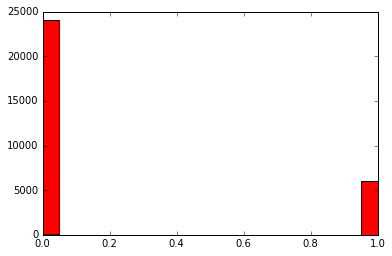

116:======================================================================
269.000000 <=PAY_AMT2 < 1600.000000
std_dev 0.398138060923
mean 0.197533333333
min 0.0
max 1.0


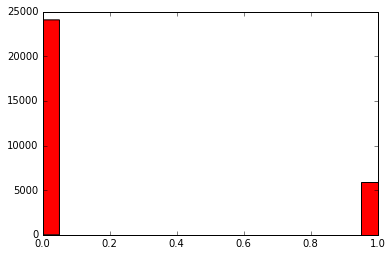

117:======================================================================
1600.000000 <=PAY_AMT2 < 3000.000000
std_dev 0.39400334883
mean 0.192166666667
min 0.0
max 1.0


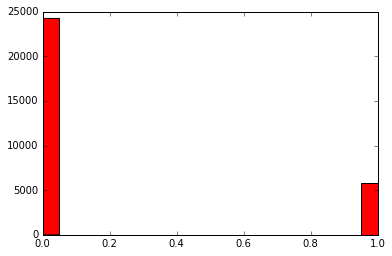

118:======================================================================
3000.000000 <=PAY_AMT2 < 6000.000000
std_dev 0.402183286022
mean 0.202933333333
min 0.0
max 1.0


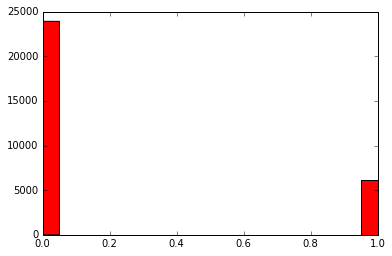

119:======================================================================
6000.000000 <=PAY_AMT2
std_dev 0.405420438831
mean 0.207366666667
min 0.0
max 1.0


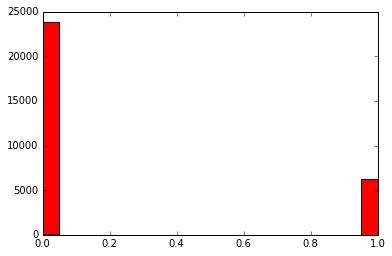

120:======================================================================
PAY_AMT3 < 3.000000
std_dev 0.4
mean 0.2
min 0.0
max 1.0


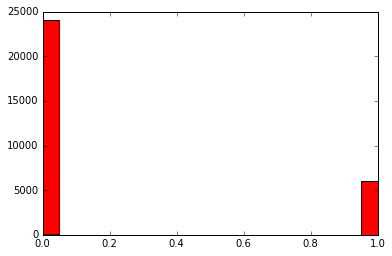

121:======================================================================
3.000000 <=PAY_AMT3 < 1206.000000
std_dev 0.399899965269
mean 0.199866666667
min 0.0
max 1.0


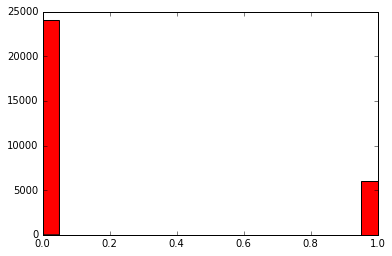

122:======================================================================
1206.000000 <=PAY_AMT3 < 2500.000000
std_dev 0.39974978285
mean 0.199666666667
min 0.0
max 1.0


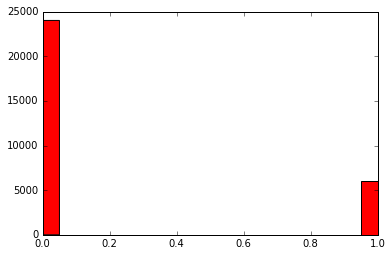

123:======================================================================
2500.000000 <=PAY_AMT3 < 5288.000000
std_dev 0.400349575024
mean 0.200466666667
min 0.0
max 1.0


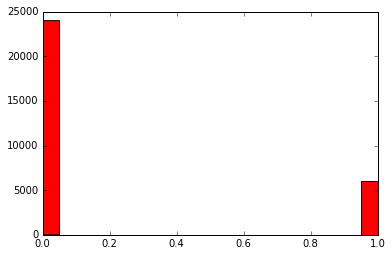

124:======================================================================
5288.000000 <=PAY_AMT3
std_dev 0.4
mean 0.2
min 0.0
max 1.0


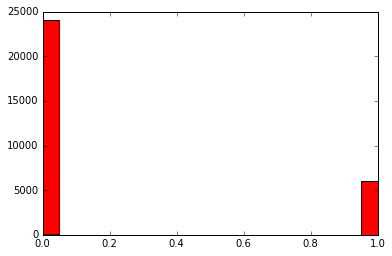

125:======================================================================
PAY_AMT4 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


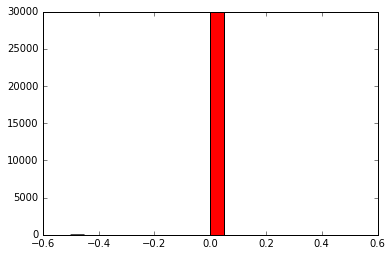

126:======================================================================
0.000000 <=PAY_AMT4 < 1000.000000
std_dev 0.485287378777
mean 0.3796
min 0.0
max 1.0


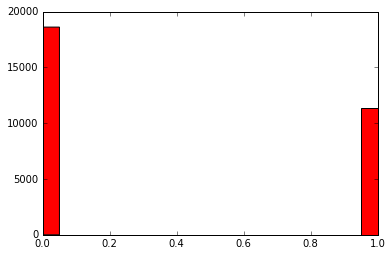

127:======================================================================
1000.000000 <=PAY_AMT4 < 2100.000000
std_dev 0.413228447714
mean 0.2185
min 0.0
max 1.0


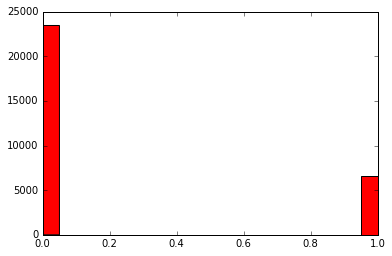

128:======================================================================
2100.000000 <=PAY_AMT4 < 5000.000000
std_dev 0.385486980613
mean 0.181566666667
min 0.0
max 1.0


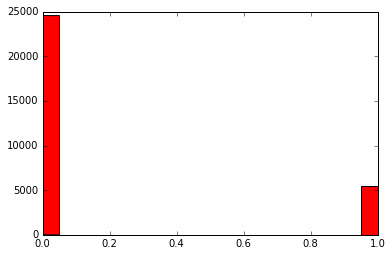

129:======================================================================
5000.000000 <=PAY_AMT4
std_dev 0.414471417055
mean 0.220333333333
min 0.0
max 1.0


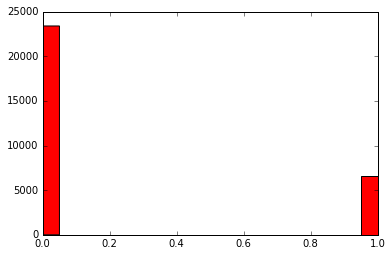

130:======================================================================
PAY_AMT5 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


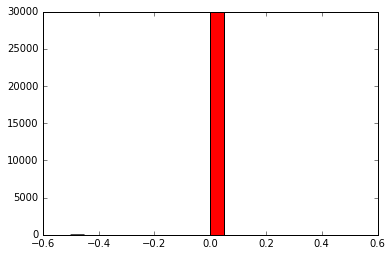

131:======================================================================
0.000000 <=PAY_AMT5 < 1000.000000
std_dev 0.485138124661
mean 0.379
min 0.0
max 1.0


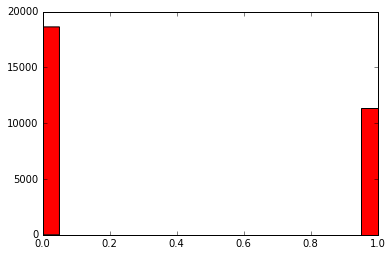

132:======================================================================
1000.000000 <=PAY_AMT5 < 2124.000000
std_dev 0.414920474308
mean 0.221
min 0.0
max 1.0


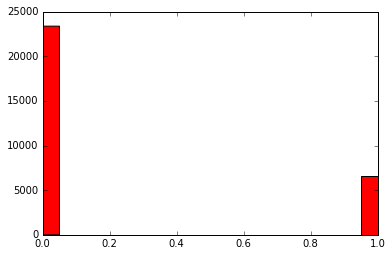

133:======================================================================
2124.000000 <=PAY_AMT5 < 5000.000000
std_dev 0.38360332376
mean 0.1793
min 0.0
max 1.0


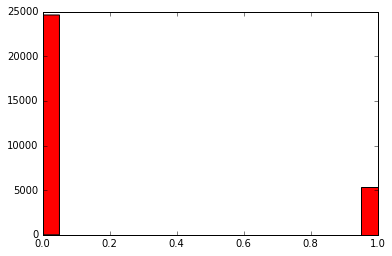

134:======================================================================
5000.000000 <=PAY_AMT5
std_dev 0.414718591336
mean 0.2207
min 0.0
max 1.0


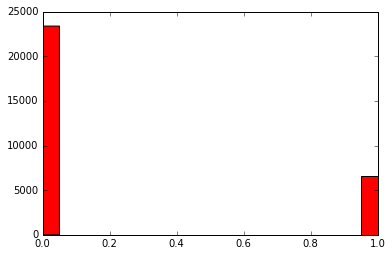

135:======================================================================
PAY_AMT6 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


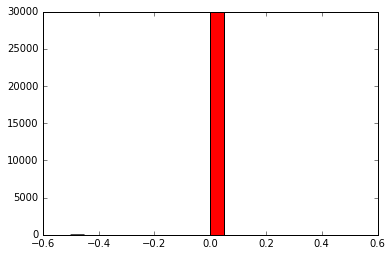

136:======================================================================
0.000000 <=PAY_AMT6 < 1000.000000
std_dev 0.487937125959
mean 0.390833333333
min 0.0
max 1.0


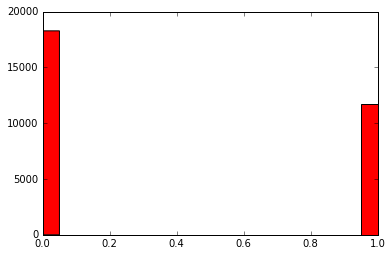

137:======================================================================
1000.000000 <=PAY_AMT6 < 2100.000000
std_dev 0.406546670821
mean 0.208933333333
min 0.0
max 1.0


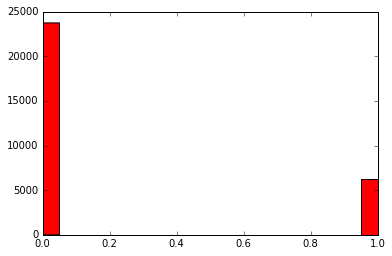

138:======================================================================
2100.000000 <=PAY_AMT6 < 5000.000000
std_dev 0.386393006608
mean 0.182666666667
min 0.0
max 1.0


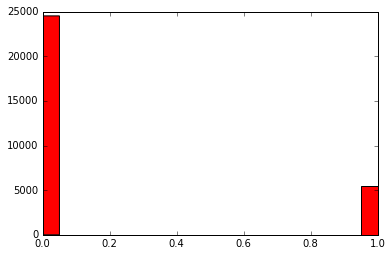

139:======================================================================
5000.000000 <=PAY_AMT6
std_dev 0.412591095665
mean 0.217566666667
min 0.0
max 1.0


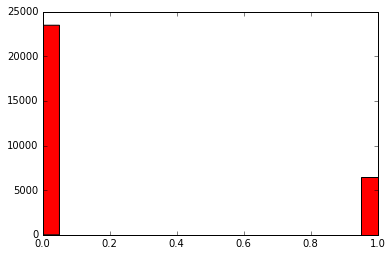

140:======================================================================
PAY_AMT1/LIMIT_BAL < 0.001548
std_dev 0.4
mean 0.2
min 0.0
max 1.0


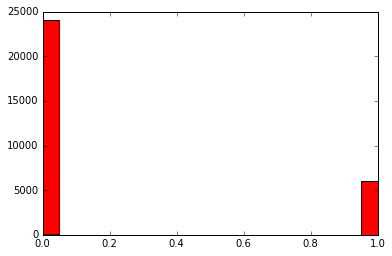

141:======================================================================
0.001548 <=PAY_AMT1/LIMIT_BAL < 0.016667
std_dev 0.399574372162
mean 0.199433333333
min 0.0
max 1.0


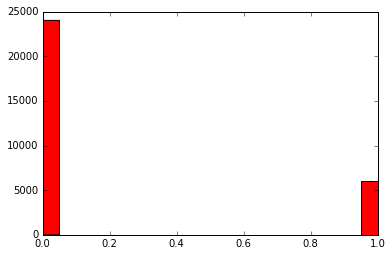

142:======================================================================
0.016667 <=PAY_AMT1/LIMIT_BAL < 0.033333
std_dev 0.396687449035
mean 0.195633333333
min 0.0
max 1.0


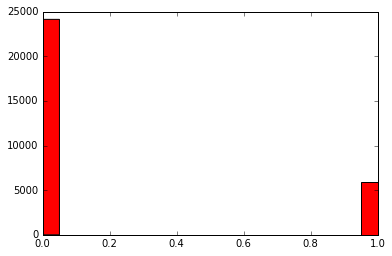

143:======================================================================
0.033333 <=PAY_AMT1/LIMIT_BAL < 0.051421
std_dev 0.403652898196
mean 0.204933333333
min 0.0
max 1.0


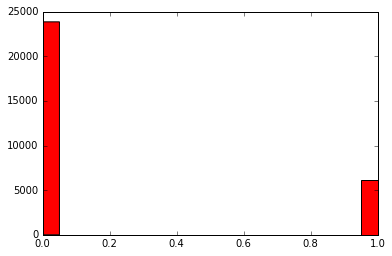

144:======================================================================
0.051421 <=PAY_AMT1/LIMIT_BAL
std_dev 0.4
mean 0.2
min 0.0
max 1.0


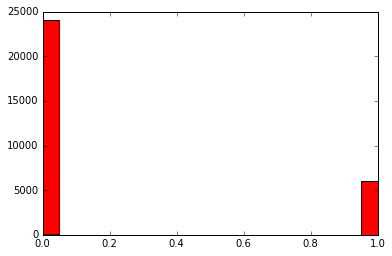

145:======================================================================
PAY_AMT2/LIMIT_BAL < 0.001250
std_dev 0.399949991318
mean 0.199933333333
min 0.0
max 1.0


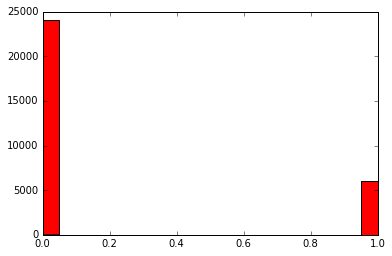

146:======================================================================
0.001250 <=PAY_AMT2/LIMIT_BAL < 0.015600
std_dev 0.400049991321
mean 0.200066666667
min 0.0
max 1.0


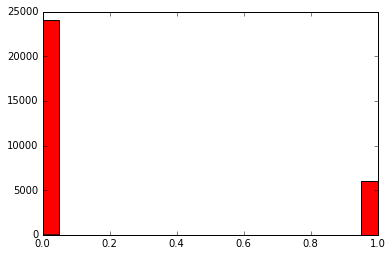

147:======================================================================
0.015600 <=PAY_AMT2/LIMIT_BAL < 0.031250
std_dev 0.399949991318
mean 0.199933333333
min 0.0
max 1.0


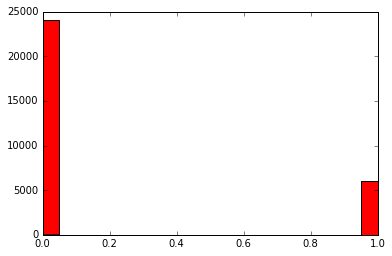

148:======================================================================
0.031250 <=PAY_AMT2/LIMIT_BAL < 0.050000
std_dev 0.390845202378
mean 0.188166666667
min 0.0
max 1.0


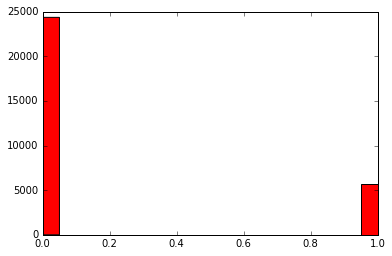

149:======================================================================
0.050000 <=PAY_AMT2/LIMIT_BAL
std_dev 0.408654364959
mean 0.2119
min 0.0
max 1.0


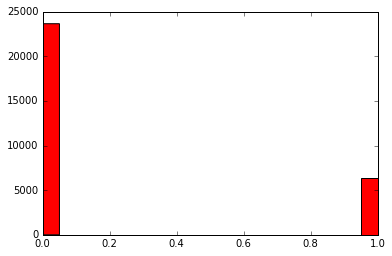

150:======================================================================
PAY_AMT3/LIMIT_BAL < 0.000015
std_dev 0.4
mean 0.2
min 0.0
max 1.0


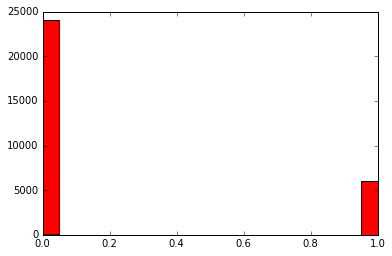

151:======================================================================
0.000015 <=PAY_AMT3/LIMIT_BAL < 0.012414
std_dev 0.4
mean 0.2
min 0.0
max 1.0


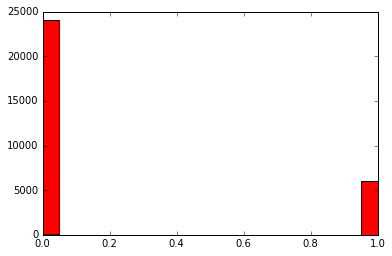

152:======================================================================
0.012414 <=PAY_AMT3/LIMIT_BAL < 0.025108
std_dev 0.4
mean 0.2
min 0.0
max 1.0


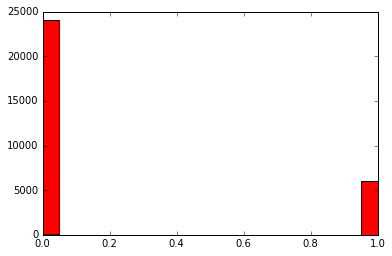

153:======================================================================
0.025108 <=PAY_AMT3/LIMIT_BAL < 0.042500
std_dev 0.399849921846
mean 0.1998
min 0.0
max 1.0


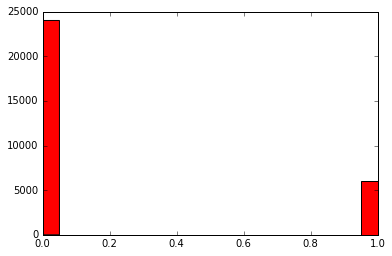

154:======================================================================
0.042500 <=PAY_AMT3/LIMIT_BAL
std_dev 0.400149921904
mean 0.2002
min 0.0
max 1.0


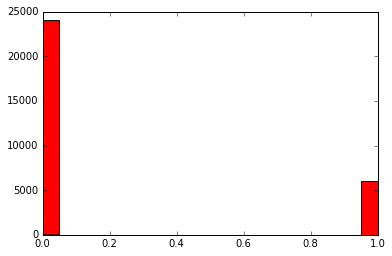

155:======================================================================
PAY_AMT4/LIMIT_BAL < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


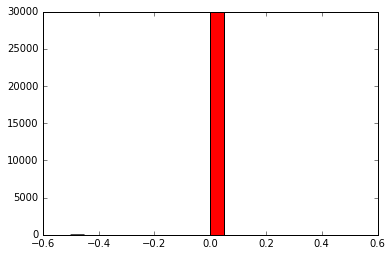

156:======================================================================
0.000000 <=PAY_AMT4/LIMIT_BAL < 0.010184
std_dev 0.489897948557
mean 0.4
min 0.0
max 1.0


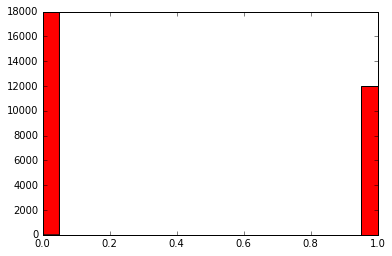

157:======================================================================
0.010184 <=PAY_AMT4/LIMIT_BAL < 0.021500
std_dev 0.399949991318
mean 0.199933333333
min 0.0
max 1.0


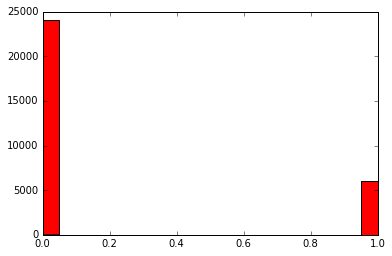

158:======================================================================
0.021500 <=PAY_AMT4/LIMIT_BAL < 0.037500
std_dev 0.398365793656
mean 0.197833333333
min 0.0
max 1.0


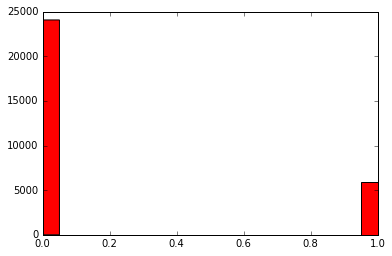

159:======================================================================
0.037500 <=PAY_AMT4/LIMIT_BAL
std_dev 0.401665298753
mean 0.202233333333
min 0.0
max 1.0


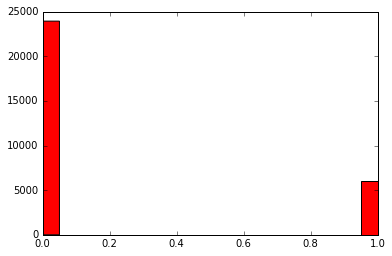

160:======================================================================
PAY_AMT5/LIMIT_BAL < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


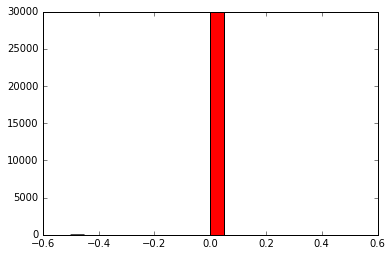

161:======================================================================
0.000000 <=PAY_AMT5/LIMIT_BAL < 0.010000
std_dev 0.489754540561
mean 0.3993
min 0.0
max 1.0


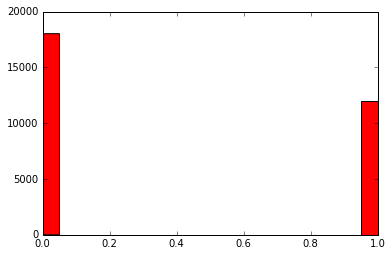

162:======================================================================
0.010000 <=PAY_AMT5/LIMIT_BAL < 0.021520
std_dev 0.400524044222
mean 0.2007
min 0.0
max 1.0


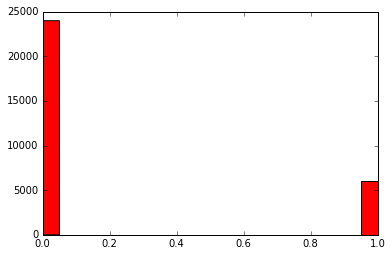

163:======================================================================
0.021520 <=PAY_AMT5/LIMIT_BAL < 0.038000
std_dev 0.399799861042
mean 0.199733333333
min 0.0
max 1.0


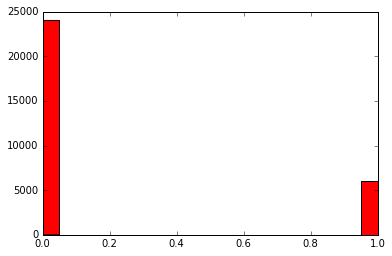

164:======================================================================
0.038000 <=PAY_AMT5/LIMIT_BAL
std_dev 0.40019986118
mean 0.200266666667
min 0.0
max 1.0


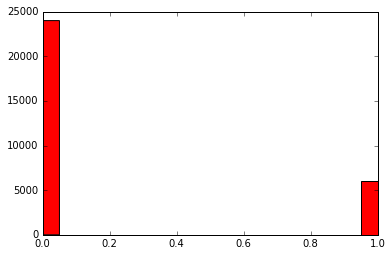

165:======================================================================
PAY_AMT6/LIMIT_BAL < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


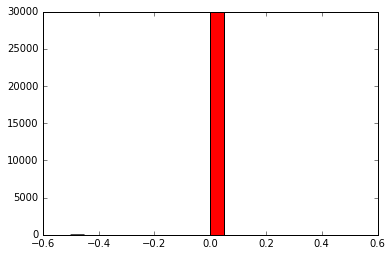

166:======================================================================
0.000000 <=PAY_AMT6/LIMIT_BAL < 0.008908
std_dev 0.489897948557
mean 0.4
min 0.0
max 1.0


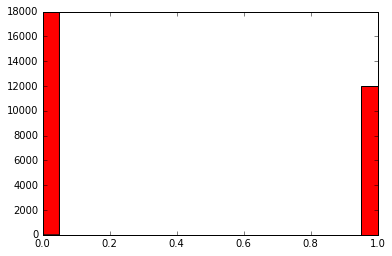

167:======================================================================
0.008908 <=PAY_AMT6/LIMIT_BAL < 0.020367
std_dev 0.4
mean 0.2
min 0.0
max 1.0


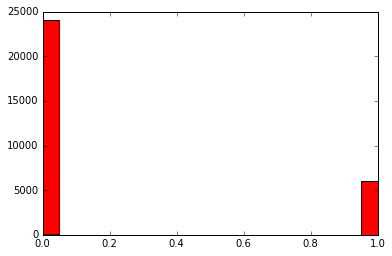

168:======================================================================
0.020367 <=PAY_AMT6/LIMIT_BAL < 0.037150
std_dev 0.4
mean 0.2
min 0.0
max 1.0


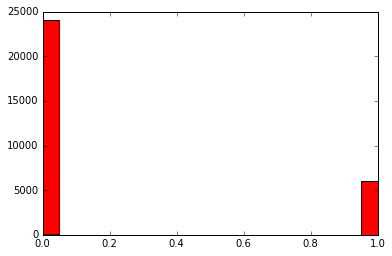

169:======================================================================
0.037150 <=PAY_AMT6/LIMIT_BAL
std_dev 0.4
mean 0.2
min 0.0
max 1.0


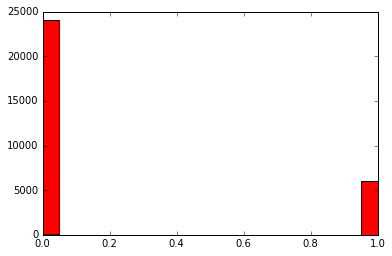

In [7]:
analyze(nf, nd)

In [23]:
save_to_csv(nd, nf, correct_answers, 'ccard_preprocessed.csv')
print("ok")

ok


In [14]:
print(1 - np.mean(correct_answers))

0.7788


In [15]:
print(nf.shape)

(30000, 170)


In [26]:
print(np.max(nf[:, 1]))
print(np.min(nf[:, 1]))
f = (nf[:, 1] - np.min(nf[:, 1]))/(np.max(nf[:, 1]) - np.min(nf[:, 1]))
print(f)

1.0
0.0
[ 0.1505149978319902659418261237078695558011531829833984375
  0.53959062302381244347060373911517672240734100341796875
  0.477121254719662324372819739437545649707317352294921875  ...,
  0.2385606273598311621864098697187728248536586761474609375
  0.451544993495971602737171224362100474536418914794921875
  0.349485002168009317724539641858427785336971282958984375 ]
